In [147]:
import os
# 提出時は足す
# !pip install pycaret -full
# 提出時は消す
os.chdir('C:\\Users\\Takanori\\Desktop\\Kaggle\\TPS2204\\input')

# Introduction
Hey, thanks for viewing my Kernel!

If you like my work, please, leave an upvote: it will be really appreciated and it will motivate me in offering more content to the Kaggle community ! :)

EDA was done in this [notebook](https://www.kaggle.com/code/hasanbasriakcay/tpsapr22-eda-fe-baseline)</br>
Pseudo Labeling was done in this [notebook](https://www.kaggle.com/code/hasanbasriakcay/tpsapr22-fe-pseudo-labels-baseline)</br>
Prediction without NN is in this [notebook](https://www.kaggle.com/code/hasanbasriakcay/tpsapr22-optuna-lgbm-blend)

In [148]:
import pandas as pd
import numpy as np
import warnings 

warnings.simplefilter("ignore")
# indexを指定しないと、PyCaretの予測結果がめちゃくちゃになる?
train = pd.read_csv("../input/tabular-playground-series-apr-2022/train.csv")
test = pd.read_csv("../input/tabular-playground-series-apr-2022/test.csv")
train_labels = pd.read_csv("../input/tabular-playground-series-apr-2022/train_labels.csv")
sub = pd.read_csv("../input/tabular-playground-series-apr-2022/sample_submission.csv")

display(train.head())
display(test.head())
display(train_labels.head())
display(sub.head())

,sequence,subject,step,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_12
0,0,47,0,-0.196291,0.112395,1.0,0.329204,-1.004660,-0.131638,-0.127505,0.368702,-0.1,-0.963873,-0.985069,0.531893,4.751492
1,0,47,1,-0.447450,0.134454,1.0,-0.658407,0.162495,0.340314,-0.209472,-0.867176,0.2,-0.301301,0.082733,-0.231481,0.454390
2,0,47,2,0.326893,-0.694328,1.0,0.330088,0.473678,1.280479,-0.094718,0.535878,1.4,1.002168,0.449221,-0.586420,-4.736147
3,0,47,3,0.523184,0.751050,1.0,0.976991,-0.563287,-0.720269,0.793260,0.951145,-0.3,-0.995665,-0.434290,1.344650,0.429241
4,0,47,4,0.272025,1.074580,1.0,-0.136283,0.398579,0.044877,0.560109,-0.541985,-0.9,1.055636,0.812631,0.123457,-0.223359


,sequence,subject,step,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_12
0,25968,684,0,2.427357,19.639706,1.0,-1.466372,-1.289973,-4.207928,2.486339,-2.493893,8.0,-1.123555,-1.673048,10.980453,0.419011
1,25968,684,1,-4.950541,-21.747899,1.0,0.983186,-0.569053,1.845924,-3.887978,1.727481,-2.9,0.395231,-0.882233,-1.871399,-0.008525
2,25968,684,2,1.136012,-10.756303,1.0,1.016814,0.964157,2.454749,0.312386,1.154198,-5.6,1.114162,1.525273,-11.584362,0.139812
3,25968,684,3,0.806028,6.504202,1.0,-0.179646,0.969221,-1.035153,-0.457195,0.254962,-2.7,-0.588873,0.608761,-4.241770,-0.462916
4,25968,684,4,1.288253,5.552521,1.0,-0.493805,-1.036124,-1.126402,2.008197,-0.730534,0.0,0.899566,-1.259615,-0.472222,-0.121483


,sequence,state
0,0,0
1,1,1
2,2,1
3,3,1
4,4,1


,sequence,state
0,25968,0
1,25969,0
2,25970,0
3,25971,0
4,25972,0


In [149]:
sensors = [col for col in train.columns if 'sensor_' in col]
train_pivoted0 = train.pivot(index=['sequence', 'subject'], columns='step', values=sensors)
test_pivoted0 = test.pivot(index=['sequence', 'subject'], columns='step', values=sensors)
display(train_pivoted0.head())

sensor_00                                                    \
step                    0         1         2         3         4         5    
sequence subject                                                               
0        47      -0.196291 -0.447450  0.326893  0.523184  0.272025 -1.073416   
1        66      -6.657651  1.633694  1.863215 -2.846213  0.593509  2.469861   
2        66      -1.741886  3.402628 -0.632148  0.208655 -0.800618 -2.274343   
3        542      0.264297 -1.808346  0.078825  1.037094 -0.189335 -1.302937   
4        437      0.567233 -0.823802  1.476816 -1.710201 -0.408810  0.556414   

                                                          ... sensor_12  \
step                    6         7         8         9   ...        50   
sequence subject                                          ...             
0        47       0.350850 -0.304482 -0.216383  0.303709  ... -1.670077   
1        66      -1.202473 -0.829212  1.091190 -0.334621  ... -0.338022   
2        66       2.009274 -0.563369 -0.050232  0.800618  ... -0.172634   
3        542      1.078825  2.257342 -2.283617 -2.759660  ...  0.145354   
4        437      0.853168 -0.406491 -0.009274 -0.021638  ...  0.001705   

                                                                              \
step                    51        52        53        54        55        56   
sequence subject                                                               
0        47      -5.306479  3.621057  4.965047 -3.615090  0.791134  5.887042   
1        66       0.234868  0.030691  0.037511 -0.120205  0.056692  0.062234   
2        66       0.091645 -0.028986 -0.202472  0.332481 -0.013214  0.245524   
3        542     -0.045610 -0.098039 -0.049446  0.055840 -0.022165  0.054135   
4        437     -0.050725 -0.025149  0.106138 -0.098465 -0.040068  0.135976   

                                                  
step                    57         58         59  
sequence subject                                  
0        47      -7.211424 -26.738704 -50.658994  
1        66      -0.013640   0.098039  -0.115090  
2        66      -0.091219  -0.306905   0.046036  
3        542     -0.185422   0.311168  -0.166240  
4        437      0.121910  -0.059676  -0.087809  

[5 rows x 780 columns]

# Feature Engineering

In [150]:
# https://www.kaggle.com/code/ambrosm/tpsapr22-best-model-without-nn
# Feature engineering
def engineer(df):
    import scipy.stats
    new_df = pd.DataFrame([], index=df.index)
    for sensor in sensors:
        # ピボットした後のdfは、columnsを指定すると、いくつかの行をまとめて取ってこれる
        new_df[sensor + '_mean'] = df[sensor].mean(axis=1)
        new_df[sensor + '_std'] = df[sensor].std(axis=1)
        new_df[sensor + '_iqr'] = scipy.stats.iqr(df[sensor], axis=1)
        """
        new_df[sensor + '_sm'] = np.nan_to_num(new_df[sensor + '_std'] / 
                                               new_df[sensor + '_mean'].abs()).clip(-1e10, 1e10)
        """
        new_df[sensor + '_kurtosis'] = scipy.stats.kurtosis(df[sensor], axis=1)
    new_df['sensor_02_up'] = (df.sensor_02.diff(axis=1) > 0).sum(axis=1)
    new_df['sensor_02_down'] = (df.sensor_02.diff(axis=1) < 0).sum(axis=1)
    new_df['sensor_02_upsum'] = df.sensor_02.diff(axis=1).clip(0, None).sum(axis=1)
    new_df['sensor_02_downsum'] = df.sensor_02.diff(axis=1) .clip(None, 0).sum(axis=1)
    new_df['sensor_02_upmax'] = df.sensor_02.diff(axis=1).max(axis=1)
    new_df['sensor_02_downmax'] = df.sensor_02.diff(axis=1).min(axis=1)
    new_df['sensor_02_upmean'] = np.nan_to_num(new_df['sensor_02_upsum'] / new_df['sensor_02_up'], posinf=32)
    new_df['sensor_02_downmean'] = np.nan_to_num(new_df['sensor_02_downsum'] / new_df['sensor_02_down'], neginf=-32)
    return new_df

# sequence別に統計量を計算する
train_pivoted = engineer(train_pivoted0)
test_pivoted = engineer(test_pivoted0)

train_shuffled = train_pivoted.sample(frac=1.0, random_state=1)  # ランダムに並び替え・・・なんのために?
labels_shuffled = train_labels.reindex(train_shuffled.index.get_level_values('sequence'))
labels_shuffled = labels_shuffled[['state']].merge(train[['sequence', 'subject']].groupby('sequence').min(),
                                                   how='left', on='sequence')
labels_shuffled = labels_shuffled.merge(labels_shuffled.groupby('subject').size().rename('sequence_count'),
                                        how='left', on='subject')
train_shuffled['sequence_count_of_subject'] = labels_shuffled['sequence_count'].values

sequence_count = test_pivoted.index.to_frame(index=False).groupby('subject').size().rename('sequence_count_of_subject')
test_pivoted = test_pivoted.merge(sequence_count, how='left', on='subject')

selected_columns = train_shuffled.columns
print(len(selected_columns))
#train_shuffled.columns

61


In [151]:
train_shuffled.head()

,,sensor_00_mean,sensor_00_std,sensor_00_iqr,sensor_00_kurtosis,sensor_01_mean,sensor_01_std,sensor_01_iqr,sensor_01_kurtosis,sensor_02_mean,sensor_02_std,...,sensor_12_kurtosis,sensor_02_up,sensor_02_down,sensor_02_upsum,sensor_02_downsum,sensor_02_upmax,sensor_02_downmax,sensor_02_upmean,sensor_02_downmean,sequence_count_of_subject
sequence,subject,,,,,,,,,,,,,,,,,,,,,
10611,242,0.001365,0.457624,0.511785,-0.263845,0.007493,0.455472,0.598739,-0.399236,0.972167,0.147560,...,-1.184657,10,9,1.841667,-1.841667,0.301667,-0.303333,0.184167,-0.204630,31
14656,536,-0.010484,0.949162,0.977589,2.037479,0.033771,0.941060,1.267595,0.080955,-0.562480,0.301252,...,-0.964355,12,11,1.826153,-1.826153,0.230000,-0.333333,0.152179,-0.166014,51
19119,245,-0.013730,1.369316,1.373068,0.982639,-0.033876,1.223950,1.284664,0.927326,0.043939,0.337321,...,-0.368137,8,12,1.333847,-2.000514,0.254607,-0.303801,0.166731,-0.166709,46
8143,547,0.013357,1.466844,1.906298,-0.329048,-0.009156,0.784275,0.943277,1.006701,-0.148191,0.265070,...,-0.402897,12,18,3.526520,-3.216998,0.951628,-0.311667,0.293877,-0.178722,51
19368,120,-0.129019,1.637407,1.941267,4.630269,0.119730,1.617296,1.282038,8.006785,-2.243534,0.548725,...,0.769453,12,18,3.472306,-4.102306,0.999486,-1.239486,0.289359,-0.227906,28


* PyCaretを使ってみる
* https://pycaret.gitbook.io/docs/

In [152]:
import pycaret
from pycaret.classification import *
from pycaret.classification import setup, compare_models, blend_models, finalize_model, predict_model, plot_model

In [153]:
# 予測対象であるstateをくっつける
train_df_label = pd.merge(train_shuffled, train_labels, how='left', on='sequence')

In [154]:
train_df_label.tail()

,sequence,sensor_00_mean,sensor_00_std,sensor_00_iqr,sensor_00_kurtosis,sensor_01_mean,sensor_01_std,sensor_01_iqr,sensor_01_kurtosis,sensor_02_mean,...,sensor_02_up,sensor_02_down,sensor_02_upsum,sensor_02_downsum,sensor_02_upmax,sensor_02_downmax,sensor_02_upmean,sensor_02_downmean,sequence_count_of_subject,state
25963,10955,0.068921,1.936319,1.423107,3.844153,0.060364,1.603716,1.257090,7.010847,-0.122675,...,5,9,0.902029,-1.902029,0.235362,-0.666667,0.180406,-0.211337,77,1
25964,17289,-0.007986,1.320915,2.068199,-0.153580,-0.021359,1.440422,1.933561,-0.468555,0.616744,...,4,4,0.665639,-0.665639,0.251279,-0.251279,0.166410,-0.166410,31,0
25965,5192,-0.018148,0.519007,0.534196,1.984689,-0.031513,0.420650,0.571954,-0.213731,0.340828,...,5,8,0.999486,-1.333333,0.333847,-0.284561,0.199897,-0.166667,97,1
25966,12172,-0.005358,0.724569,0.746909,0.165472,-0.027679,0.729696,0.933561,-0.366121,-0.095579,...,10,11,1.582820,-2.582306,0.250385,-0.666153,0.158282,-0.234755,79,1
25967,235,-0.003014,0.790997,0.803709,0.650815,0.026383,0.558247,0.799107,-0.127523,-1.127264,...,7,6,2.225000,-1.558333,1.000000,-0.666667,0.317857,-0.259722,37,0


In [155]:
train_df_label.dtypes

sequence                       int64
sensor_00_mean               float64
sensor_00_std                float64
sensor_00_iqr                float64
sensor_00_kurtosis           float64
                              ...   
sensor_02_downmax            float64
sensor_02_upmean             float64
sensor_02_downmean           float64
sequence_count_of_subject      int64
state                          int64
Length: 63, dtype: object

In [156]:
feature_selection_threshold_ = 0.2  # 0.1で25項目, 0.2で67項目

In [157]:
# https://qiita.com/tomiyou/items/e1842775e7aaee04ada3
clf1 = setup(data = train_df_label,
             target = 'state',  # 目標変数
             ignore_features =['sequence'],
             fold_strategy = 'groupkfold',
             fold_groups = 'sequence',
             use_gpu = True,
             # 1. 欠損値の処理
             # imputation_type: 代入の方法
             # simple:
             # iterative: 不明、たぶん反復的に欠損値を補っていく
             imputation_type='iterative',
             # nude_imputation: 欠損値の補完方法
             # mean: 平均値
             # median: 中央値
             # zero: 0
             numeric_imputation = 'mean',
             # categorical_imputation: カテゴリ変数の保管方法
             # constant: not_availableという文字列で埋める
             # mode: 最頻値で埋める
             # categorical_features='constant',
             # iterative_imputation_iters: 多分、欠損値をlightgbmとか使って埋める設定
             # iterative_imputation_iters=5,
             # numeric_iterative_imputer='lightgbm',
             # categorical_iterative_imputer='lightgbm',
             # 2. カテゴリ変数変換
             # カテゴリ変数は自動でone-hotに変換される
             # ただし、パラメータ数が増えすぎてしまうことがあるため、調整することが可能
             # https://pycaret.gitbook.io/docs/get-started/preprocessing/data-preparation#ordinal-encoding
             # TODO
             # 1. スケールと変換: 正規化等の設定
             # normalize: パラメータを正規化する
             normalize=True,
             # normalize_method: パラメータを正規化する方法
             # z-score: 平均0, 標準偏差1になるようにスケール変換する (x-u)/σ
             # minmax: [0, 1]の範囲に収まるように変換する。 (x-min)/(max-min)
             # maxabs: 絶対値が1.0になるように、定数倍する。 (x/max(abs(x)))
             # robust: 四分位に従ってスケーリングする。外れ値が含まれているときは良い結果をもたらす
             normalize_method = 'robust',
             # 2. 特徴変換
             feature_interaction = True,  # パラメータに、変数間の積を追加する
             feature_ratio = True,  # パラメータに、変数間の比率を追加する
             feature_selection= True, # 特徴量選択を行う
             feature_selection_threshold = feature_selection_threshold_,  # 特徴量選択後に使われるパラメータ数、大きいほどたくさん残る
             # pca = True,  # PCAを行い、パラメータの次元圧縮を行う
             # ignore_low_variance = True,  # 統計的に重要でない分散を持つ特徴量を除外
             # combine_rare_levels = True,  # 出現頻度の少ないカテゴリ特徴量をまとめる
             # remove_outliers = True,  # 外れ値を除外する
             remove_multicollinearity = True,  # 多変量性を除外する
             remove_perfect_collinearity = True,  # 完全相関を除外する
             polynomial_features = True, # 多項式特徴量を作成する
             polynomial_degree = 2,  # 多項式の次数
             # trigonometry_features = True,  # 三角関数を作成する
             silent = True,  # 対話的な設定を無効化
             # profile=True,  # インタラクティブなEDAレポート
             fold = 10
             )

,Description,Value
0,session_id,8838
1,Target,state
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(25968, 63)"
5,Missing Values,False
6,Numeric Features,61
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [158]:
clf1[0].head()

,sensor_10_mean,sensor_08_std,sensor_06_kurtosis,sensor_02_down,sensor_02_std,sensor_04_kurtosis,sensor_01_kurtosis,sensor_02_downsum,sensor_02_mean,sensor_04_kurtosis_Power2,...,sensor_04_kurtosis_Power2_divide_sensor_02_down,sensor_11_kurtosis_multiply_sequence_count_of_subject,sequence_count_of_subject_multiply_sensor_04_kurtosis,sensor_02_upmean_divide_sensor_02_upmean_Power2,sequence_count_of_subject_multiply_sensor_03_kurtosis,sensor_04_kurtosis_Power2_multiply_sensor_04_kurtosis,sequence_count_of_subject_multiply_sensor_06_kurtosis,sensor_12_mean_divide_sensor_12_std,sensor_02_upmean_Power2_divide_sensor_02_upmean,sensor_08_std_divide_sensor_04_kurtosis_Power2
0,0.210819,0.016794,-0.493648,0.6,-0.447990,-0.456110,-0.397515,-0.807354,1.053112,0.195172,...,0.325286,0.079945,0.185295,1.097810,0.189251,-0.089020,0.200545,1.614634,0.910904,0.086046
1,-1.398774,0.113951,-0.392326,1.0,0.412497,1.718654,-0.244845,-0.791848,-0.602691,7.267406,...,7.267406,-0.072080,0.375956,1.206886,-0.106852,12.490158,-0.085821,40.289326,0.828579,0.015680
2,-1.032076,-0.486610,0.056294,1.2,0.614440,0.101821,0.024246,-0.966119,0.051603,-0.446205,...,-0.371837,0.083396,0.006364,1.154695,-0.006283,-0.045433,0.003518,-8.266581,0.866030,1.090554
3,0.349206,0.528786,-0.132065,2.4,0.209922,0.875921,0.049482,-2.181979,-0.155694,1.470960,...,0.612900,0.013796,0.191608,0.838037,0.080163,1.288445,-0.028889,-3.256305,1.193264,0.359484
4,-0.831901,0.713185,-0.231799,2.4,1.798045,1.801535,2.275054,-3.066833,-2.416460,8.046321,...,3.352633,-5.343939,-0.900768,0.846284,-5.277739,14.495732,0.115899,15.905024,1.181637,0.088635


In [159]:
# 学習が進んできたらモデルを比較する。一旦はlightgbmでもそれなりに見れているのでこれで
best_models = compare_models(n_select=5)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.8681,0.9391,0.8974,0.8476,0.8718,0.7362,0.7375,33.5400
lightgbm,Light Gradient Boosting Machine,0.8618,0.9357,0.8892,0.8429,0.8654,0.7236,0.7247,3.8060
xgboost,Extreme Gradient Boosting,0.8604,0.9321,0.8858,0.8427,0.8637,0.7207,0.7217,1.8870
gbc,Gradient Boosting Classifier,0.8531,0.9299,0.8844,0.8322,0.8574,0.7062,0.7077,69.6530
rf,Random Forest Classifier,0.8526,0.9269,0.8854,0.8307,0.8571,0.7051,0.7067,6.1810
et,Extra Trees Classifier,0.8435,0.9225,0.8880,0.8152,0.8500,0.6869,0.6897,4.2300
ada,Ada Boost Classifier,0.8385,0.9171,0.8511,0.8302,0.8404,0.6770,0.6773,14.0870
lda,Linear Discriminant Analysis,0.7904,0.8686,0.7858,0.7929,0.7893,0.5808,0.5809,0.4670
ridge,Ridge Classifier,0.7903,0.0000,0.7857,0.7928,0.7891,0.5805,0.5807,0.1550
dt,Decision Tree Classifier,0.7867,0.7868,0.7820,0.7892,0.7854,0.5734,0.5736,4.1540


In [160]:
tuned_models = [tune_model(i, optimize='Accuracy') for i in best_models]
blender = blend_models(tuned_models)
stacker = stack_models(tuned_models)
best_Accuracy_model = automl(optimize = 'Accuracy')
best_Accuracy_model = calibrate_model(best_Accuracy_model)
best_Accuracy_model = optimize_threshold(best_Accuracy_model)
best_Accuracy_model = automl(optimize = 'Accuracy')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8674,0.9404,0.8976,0.8509,0.8736,0.7344,0.7356
1,0.8685,0.9423,0.8861,0.8570,0.8713,0.7370,0.7375
2,0.8740,0.9430,0.8970,0.8585,0.8773,0.7480,0.7488
3,0.8542,0.9269,0.8769,0.8432,0.8597,0.7081,0.7087
4,0.8570,0.9326,0.8885,0.8351,0.8610,0.7140,0.7155
5,0.8674,0.9331,0.8947,0.8491,0.8713,0.7348,0.7359
6,0.8669,0.9400,0.8836,0.8533,0.8682,0.7338,0.7343
7,0.8718,0.9441,0.8816,0.8614,0.8713,0.7436,0.7438
8,0.8734,0.9432,0.8900,0.8573,0.8733,0.7469,0.7474


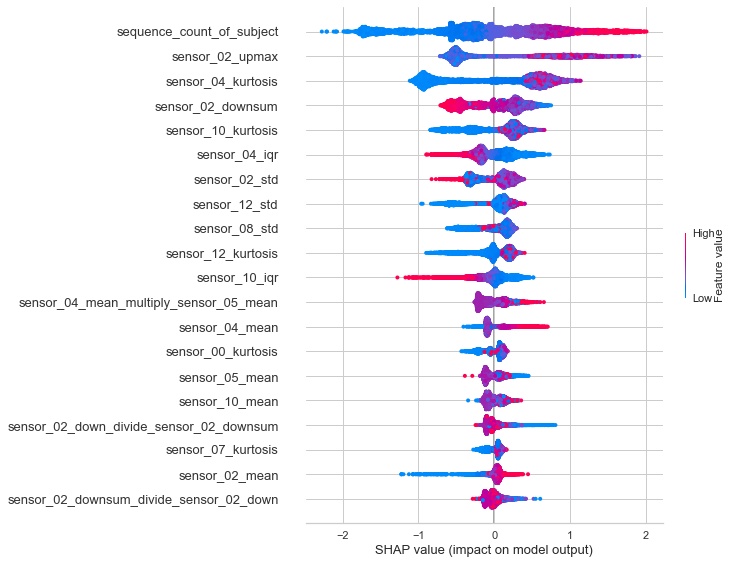

In [161]:
interpret_model(best_Accuracy_model)

In [162]:
final_model = finalize_model(best_Accuracy_model)  # ボールドアウトセットを含む、すべてのデータセットでトレーニングしなおす


In [163]:
best_params = final_model.get_params()

In [164]:
pred = predict_model(final_model, data=test_pivoted)

In [165]:
pred.head()

,sensor_00_mean,sensor_00_std,sensor_00_iqr,sensor_00_kurtosis,sensor_01_mean,sensor_01_std,sensor_01_iqr,sensor_01_kurtosis,sensor_02_mean,sensor_02_std,...,sensor_02_down,sensor_02_upsum,sensor_02_downsum,sensor_02_upmax,sensor_02_downmax,sensor_02_upmean,sensor_02_downmean,sequence_count_of_subject,Label,Score
subject,,,,,,,,,,,,,,,,,,,,,
684,-0.002602,1.091741,1.078632,6.400715,-0.036432,4.499484,0.990284,13.679216,0.883711,0.291290,...,8,0.666667,-1.332820,0.176667,-0.176667,0.166667,-0.166602,70,1,0.7925
935,0.028516,1.450040,0.844281,6.634402,0.002276,0.775379,1.079832,0.125149,0.272902,0.184520,...,9,1.226502,-1.560349,0.559836,-0.228685,0.245300,-0.173372,59,1,0.9533
924,0.057664,5.083618,6.590224,0.485832,-0.021796,2.903657,4.217700,-0.772405,-0.617986,0.116012,...,2,0.333333,-0.333333,0.295000,-0.261667,0.166667,-0.166667,38,0,0.9959
769,-0.004791,0.914917,1.034583,0.951666,0.014863,0.950923,1.095063,0.485525,-0.580709,0.142112,...,1,0.405000,-0.071667,0.203333,-0.071667,0.135000,-0.071667,70,1,0.7256
764,-0.001443,2.783685,0.857612,25.700057,-0.025350,23.942241,1.266544,24.650200,-0.164191,0.160825,...,6,0.570786,-0.903606,0.201356,-0.312851,0.114157,-0.150601,49,1,0.5519


In [166]:
sub.head()

,sequence,state
0,25968,0
1,25969,0
2,25970,0
3,25971,0
4,25972,0


In [167]:
pred['Label']

subject
684    1
935    1
924    0
769    1
764    1
      ..
980    1
915    1
872    0
835    0
773    0
Name: Label, Length: 12218, dtype: int32

In [168]:
sub = pd.read_csv("../input/tabular-playground-series-apr-2022/sample_submission.csv")
sub

,sequence,state
0,25968,0
1,25969,0
2,25970,0
3,25971,0
4,25972,0
...,...,...
12213,38181,0
12214,38182,0
12215,38183,0
12216,38184,0


In [169]:
sub['state'] = pred.reset_index()['Label']

In [170]:
sub.to_csv('submission.csv', index=False)
sub

,sequence,state
0,25968,1
1,25969,1
2,25970,0
3,25971,1
4,25972,1
...,...,...
12213,38181,1
12214,38182,1
12215,38183,0
12216,38184,0
